## Материалы:
* [Презентация] (https://disk.yandex.ru/i/AugyBVBHT4UDQg)

**Название проекта**

📞
Телеком — Поиск клиента с неоптимальными тарифами


**Описание проекта**

Провайдер виртуальной телефонии "Нупозвони" (клиент) хочет удержать колл-центры для этого ему необходимо провести исследование по оптимизации их расходов. В результате этого исследования колл-центрам будет предложено перейти на более выгодные тарифы обслуживания, что в дальнейшем обернется лояльночтью клиентов, их меньшим оттоком к конкурентам и возможно расширением клиентской базы.


**Описание данных**

Клиент предостваил "сырые" агрегированные данные


Датасет /datasets/telecom_dataset.csv

    - user_id — идентификатор клиента;
	- date — дата статистики;
	- direction — направление вызовов: out — исходящий вызов, in — входящий;
	- internal — маркер внутренних и внешних вызовов;
	- operator_id — идентификатор оператора;
	- is_missed_call — маркер пропущенных вызовов;
	- calls_count — количество звонков;
	- call_duration — длительность звонка без учёта времени ожидания;
	- total_call_duration — длительность звонка с учётом времени ожидания.

Датасет /datasets/telecom_clients.csv

	- user_id — идентификатор клиента;
	- tariff_plan — тарифный план клиента;
	- date_start — дата регистрации клиента в сервисе.


**Цель проекта**

    Проверить полученные знания в курсе Аналитик данных в тренажёре на практике и решить аналитический кейс.
    Дать ответ на запрос клиента по оптимизации расходов колл-центров тем самым повысить их лояльность.

## Предобработка данных
### Импорт только необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

### Подключение данных в проект


In [2]:
clients = pd.read_csv('/datasets/telecom_clients.csv', sep=',')
df = pd.read_csv('/datasets/telecom_dataset.csv', sep=',')

#настроим вывод так чтобы текст в ячейке отражался полностью вне зависимости от длины
pd.set_option('display.max_colwidth', None)

display(clients.head())
display(df.head())

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


### Проверка на дубли данных, явные и неявные

In [3]:
print('явных дубликатов',df.duplicated().sum())
#найдем процент дубликатов от общего количества
print('процент дубликатов от общего количества',"{0:.3%}".format(df.duplicated().sum() / len(df)))

явных дубликатов 4900
процент дубликатов от общего количества 9.091%


удалим явные дубликаты

In [4]:
df = df.drop_duplicates().reset_index(drop=True)
print('явных дубликатов',df.duplicated().sum())
df.shape

явных дубликатов 0


(49002, 9)

In [5]:
print('уникальные значения поле direction', df['direction'].unique())

уникальные значения поле direction ['in' 'out']


In [6]:
print('уникальные значения поле internal', df['internal'].unique())

уникальные значения поле internal [False True nan]


In [7]:
print('уникальные значения поле is_missed_call', df['is_missed_call'].unique())

уникальные значения поле is_missed_call [ True False]


неявных дубликатов нет

### Оценка количества пропущенных значений и принятие решения о восстановлении или удалении

In [8]:
display(clients.info())
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              49002 non-null  int64  
 1   date                 49002 non-null  object 
 2   direction            49002 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          41546 non-null  float64
 5   is_missed_call       49002 non-null  bool   
 6   calls_count          49002 non-null  int64  
 7   call_duration        49002 non-null  int64  
 8   total_call_duration  49002 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.0+ MB


None

In [9]:
df.isnull().sum()

user_id                   0
date                      0
direction                 0
internal                110
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

#### Посмотрим на пропуски в поле internal

In [10]:
print(df[df['internal'].isnull()]['total_call_duration'].count(),
      'звонков, продолжительностью',
      df[df['internal'].isnull()]['total_call_duration'].sum(),
      'минут - сумма звонков неопределенного статуса, что составляет',
      "{0:.4%}".format(df[df['internal'].isnull()]['total_call_duration'].sum()/df['total_call_duration'].sum()),
      'процента суммы минут звонков от общего количества минут'
     )

110 звонков, продолжительностью 8988 минут - сумма звонков неопределенного статуса, что составляет 0.0159% процента суммы минут звонков от общего количества минут


количество минут несущественно в общей массе и может быть безболезненно удалено

In [11]:
df = df.dropna(subset=['internal'])
print(df.isnull().sum())
df.shape

user_id                   0
date                      0
direction                 0
internal                  0
operator_id            7401
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64


(48892, 9)

#### Посмотрим на пропуски в поле operator_id

In [12]:
df[df['operator_id'].isnull()].groupby('is_missed_call')['is_missed_call'].count()

is_missed_call
False     113
True     7288
Name: is_missed_call, dtype: int64

Основная масса звонков для неизвестных операторов пропущенные, значит можно пренебречь ими и оставить без изменений. Для того чтобы в поле небыло пропущеных значений вставим вместо пропусков user_id.

In [13]:
def cuid(uid):
    if pd.isna(uid['operator_id']):
        return uid['user_id']
    else:
        return uid['operator_id']

df['operator_id'] = df.apply(cuid, axis=1)
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,166377.0,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


### Проверка и изменение типов данных на нужные для выбранных столбцов

In [14]:
clients['date_start'] = pd.to_datetime(clients['date_start'])
df['date'] = pd.DatetimeIndex(df['date']).date
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df = df.astype({'internal': 'boolean', 'operator_id': 'Int64'})
display(clients.info())
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  boolean       
 4   operator_id          48892 non-null  Int64         
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
dtypes: Int64(1), bool(1), boolean(1), datetime64[ns](1), int64(4), object(1)
memory usage: 3.2+ MB


None

**Вывод**

    Названия столбцов в датасетах корректны
    Датасет clients 
           содержит 732 строки пропусков в данных нет, 
           для поля date_start преобразован тип.
    Датасет dt
        содержит 53902 строки
        удалены явные дубликаты
        Пропуски в 
            поле internal (удалены из-за малого количества) и 
            operator_id (оставлено без изменений т.к. не повлияет на рачеты, основная масса пропущеные звонки)
        Поля date, internal и operator_id  - преобразован тип данных
        после обработки датасет содержит 48892 строки
        
данные можно считать достаточными для исследования

## Исследовательский анализ данных
### Проверка на аномалии и принятие решения на их устранение

array([[<AxesSubplot:title={'center':'user_id'}>,
        <AxesSubplot:title={'center':'date'}>],
       [<AxesSubplot:title={'center':'operator_id'}>,
        <AxesSubplot:title={'center':'calls_count'}>],
       [<AxesSubplot:title={'center':'call_duration'}>,
        <AxesSubplot:title={'center':'total_call_duration'}>]],
      dtype=object)

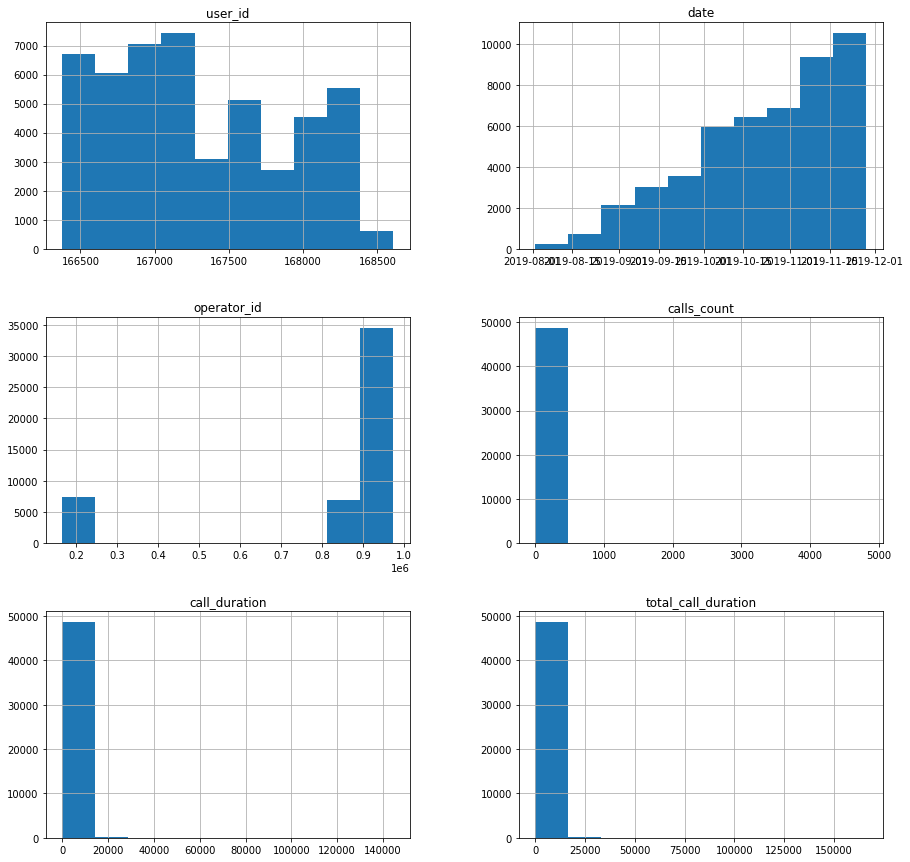

In [15]:
df.hist(figsize=(15, 15))

Похоже имеются аномалии в столбцах calls_count, call_duration, total_call_duration. Рассмотрим эти поля подробнее.

#### Аномалия  calls_count

найдем количество звонков сделаных каждым оператором за день

In [16]:
df.groupby(['date','operator_id'])['calls_count'].sum().sort_values(ascending=False)

date        operator_id
2019-11-11  929428         5022
2019-10-01  885876         2767
2019-10-31  929428         2730
2019-09-24  885876         2325
2019-09-17  885876         2206
                           ... 
2019-10-29  166708            1
            166782            1
            166803            1
            166839            1
2019-10-26  166392            1
Name: calls_count, Length: 26639, dtype: int64

In [17]:
display(df.groupby(['date','operator_id'])['calls_count'].sum().describe())
print((1/(60*24/df.groupby(['date','operator_id'])['calls_count'].sum().max())).round(2), 
      'звонка совершается каждую минуту в случае максимальной аномалии')

count    26639.000000
mean        30.274560
std        107.698868
min          1.000000
25%          2.000000
50%          6.000000
75%         24.000000
max       5022.000000
Name: calls_count, dtype: float64

3.49 звонка совершается каждую минуту в случае максимальной аномалии


Складывается впечатление, что за большим количеством звонков у клиентов скрываются боты-звонилки или это входящие звонки. Если звонки исходящие, то бот не дозвонился и перешел к следующему звонку и это хорошо для оператора. Если звонки входящие, то скорее всего абонент не дождался ответа и тут колл-центр должен увеличить свою мощность, что опять же хорошо для нашего клиента.

Оставляем как есть эту аномалию.

#### Аномалия call_duration



найдем суммарную продолжительность звонков сделаных каждым оператором за день

In [18]:
df_caldur = df.groupby(['date','operator_id'])['call_duration'].sum().sort_values(ascending=False).reset_index(drop=False)

display(df_caldur['call_duration'].describe())
print('без учета пропущеных звонков')
display(df_caldur[df_caldur['call_duration']>0]['call_duration'].describe())

print('Количество минут -', 24 * 60, ', секунд -',24*60*60,' в сутках')

count     26639.000000
mean       1593.250385
std        5192.959457
min           0.000000
25%           0.000000
50%         250.000000
75%        1528.000000
max      145006.000000
Name: call_duration, dtype: float64

без учета пропущеных звонков


count     18956.000000
mean       2239.005961
std        6037.493066
min           1.000000
25%         180.000000
50%         770.500000
75%        2339.250000
max      145006.000000
Name: call_duration, dtype: float64

Количество минут - 1440 , секунд - 86400  в сутках


Более 1440 минут не может быть длительность звонка в сутках для одного оператора. Похоже какая-то ошибка. Нужно удалить все значения больше 1440 минут, но таких значений слишком много примерно 25%. Скорее всего время в логе больше 1440 представлено в секундах, попробуем преобразовать эти значения в минуты и проверить еще раз на аномальные значения.

найдем список операторов с аномальными значениями

определим список операторов для превышен максимально возможное продолжительность звонка в сутки

In [19]:
df_caldur_opid = df_caldur[df_caldur['call_duration']>(24*60*60)]['operator_id'].unique()
df_caldur_opid

array([885876])

только один оператор с значением превышающий значение. Возможно клиент нарушает соглашение и использует для одного оператора несколько точек доступа. Посмотрим сколько записей для этого оператора имеется в логе.

In [20]:
print(df[df['operator_id'].isin(df_caldur_opid)]['call_duration'].count(), 'записи имеется для оператора')

283 записи имеется для оператора


In [21]:
print("{0:.2%}".format(df[df['operator_id'].isin(df_caldur_opid)]['call_duration'].count()/df['call_duration'].count()), 
      'от общего количества'
     )

0.58% от общего количества


удалим записи оператора с аномальными значениями

In [22]:
df = df[~df['operator_id'].isin(df_caldur_opid)]
display(df[df['call_duration']>0]['call_duration'].describe())

count    27600.000000
mean      1379.661014
std       3427.218181
min          1.000000
25%        106.000000
50%        431.000000
75%       1394.000000
max      72094.000000
Name: call_duration, dtype: float64

#### Аномалия total_call_duration

In [23]:
display(df['total_call_duration'].describe())
print('Количество минут -', 24 * 60, ', секунд -',24*60*60,' в сутках')

count    48609.000000
mean      1047.777984
std       3205.676591
min          0.000000
25%         46.000000
50%        207.000000
75%        887.000000
max      82634.000000
Name: total_call_duration, dtype: float64

Количество минут - 1440 , секунд - 86400  в сутках


После удаления оператора с аномальными значениями из поля call_duration, в поле total_call_duration также не наблюдается аномалий

### Определение данными за какой период мы располагаем, поиск максимальной и минимальной даты и определение какой период будет использоваться для анализа

In [24]:
print(
    'Дата начала сбора статистики',
    df['date'].min())
print(
    'Дата окончания',
    df['date'].max())

Дата начала сбора статистики 2019-08-02 00:00:00
Дата окончания 2019-11-28 00:00:00


In [25]:
df['month'] = pd.to_datetime(df['date']).dt.month
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month
0,166377,2019-08-04,in,False,166377,True,2,0,4,8
1,166377,2019-08-05,out,True,880022,True,3,0,5,8
2,166377,2019-08-05,out,True,880020,True,1,0,1,8
3,166377,2019-08-05,out,True,880020,False,1,10,18,8
4,166377,2019-08-05,out,False,880022,True,3,0,25,8


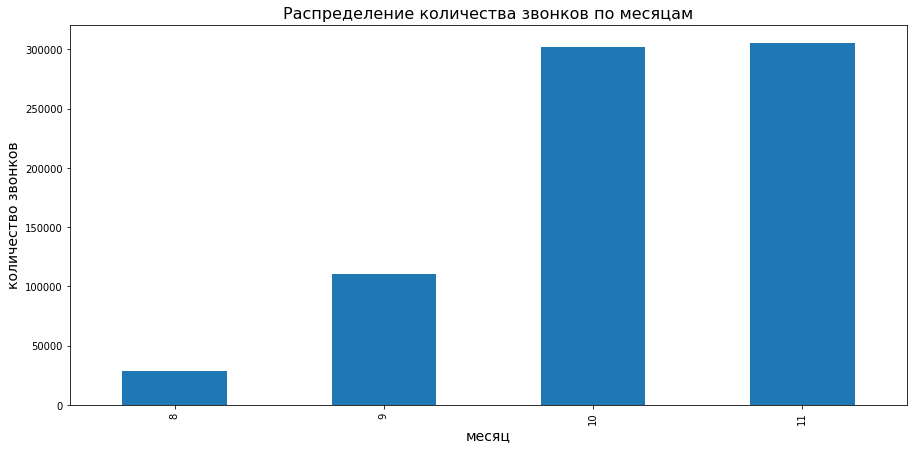

In [26]:
df.groupby(['month'])['calls_count'].sum().plot(kind='bar',figsize=(15, 7))
plt.title('Распределение количества звонков по месяцам', fontsize=16)
plt.xlabel('месяц', fontsize=14)
plt.ylabel('количество звонков', fontsize=14)
plt.show()

активность клиентов растет по месяцам равномерно и не понятно какой период нужно отбросить. Посмотрим на это по неделям, добавим поле с номером недели и оценим

In [27]:
df['week'] = df['date'].dt.isocalendar().week
df.head(1)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,week
0,166377,2019-08-04,in,False,166377,True,2,0,4,8,31


Построим диаграмму распределения звонков по неделям

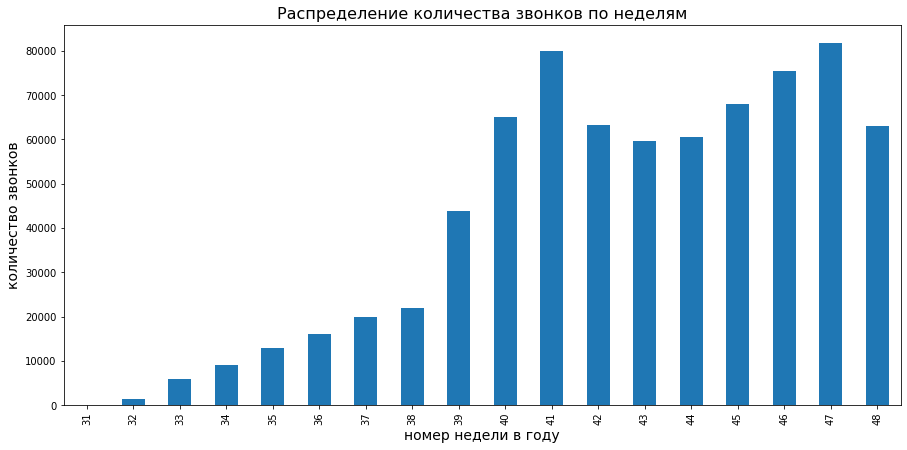

In [28]:
df.groupby(['week'])['calls_count'].sum().plot(kind='bar',figsize=(15, 7))
plt.title('Распределение количества звонков по неделям', fontsize=16)
plt.xlabel('номер недели в году', fontsize=14)
plt.ylabel('количество звонков', fontsize=14)
plt.show()

Самая большая активность в ноябре 2019 года

резкий рост количества звонков начался на 39 неделе (последняя неделя сентября), думаю можно удалить из исследования август, т.к. данные не сначала месяца и активность клиентов очень мала. Что касается неполного месяца в ноябре, то скорее всего это повлияет на общую выручку клиента в нашем исследовании

In [29]:
df=df[df['month']!=8]
display(df.sort_values(by='date').head())
print('количество дней сентября в которые имеются записи в логе составляет',df[df['month']==9]['date'].nunique(),'дней. Пропусков нет!')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,week
14210,166901,2019-09-01,in,False,166901,True,2,0,67,9,35
9270,166678,2019-09-01,out,True,900894,True,1,0,0,9,35
9269,166678,2019-09-01,out,False,900892,False,2,616,642,9,35
9268,166678,2019-09-01,out,False,900892,True,7,0,62,9,35
9267,166678,2019-09-01,in,True,900892,False,1,20,24,9,35


количество дней сентября в которые имеются записи в логе составляет 30 дней. Пропусков нет!


### Определение активных клиентов

Будем считать активными клиентов которые имели активность в последнем месяце исследуемого периода 

Последний месяц исследуемого периода - ноябрь 2019 года

In [30]:
print("{0:.2%}".format(df[df['month']==df['month'].max()]['user_id'].nunique()/df['user_id'].nunique()),
      'активных пользователей'
     )

86.14% активных пользователей


In [31]:
active_usr = df[df['month']==df['month'].max()]['user_id'].unique()
print('список активных пользователей\n', active_usr)

список активных пользователей
 [166377 166391 166392 166405 166406 166407 166428 166482 166485 166487
 166495 166503 166511 166520 166533 166536 166541 166548 166582 166585
 166604 166609 166619 166636 166649 166658 166660 166669 166677 166678
 166680 166688 166691 166692 166697 166708 166711 166713 166717 166725
 166726 166732 166774 166782 166800 166803 166812 166813 166833 166836
 166837 166839 166843 166879 166884 166896 166899 166901 166916 166939
 166940 166971 166973 166974 166975 166983 166985 166997 167002 167003
 167004 167016 167031 167035 167052 167059 167060 167061 167071 167077
 167078 167079 167082 167102 167109 167110 167112 167114 167139 167150
 167158 167162 167172 167175 167176 167180 167183 167185 167188 167199
 167200 167235 167238 167242 167246 167250 167263 167264 167265 167272
 167275 167277 167286 167338 167359 167364 167397 167402 167412 167436
 167445 167451 167455 167456 167466 167471 167475 167479 167487 167497
 167506 167521 167532 167533 167534 167543 167

**Вывод**


    Данные содержали аномальные значения и так как эти аномальные значения были только для одного оператора доля которого 0.58% от общего количества записей, то было принято решение удалить данного опреатора.
    Мы распологаем предоставленными данными за 4 месяца (08.19-11.19), больше всего данных предоставлено за ноябрь.
    Активных бользователей примерно 85% от общего количества.

## Основные вопросы исследования

### Объединение датасетов для того чтобы выполнить расчеты и добавить дополнительные столбцы для выполнения анализа

In [32]:
data = df.merge(clients, left_on = 'user_id', right_on = 'user_id')
#display(data.head())
display(data.head(1))
print(data[~data['user_id'].isin(clients['user_id'])]['user_id'].count(),'записей было пропушено при объединении таблиц')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,week,tariff_plan,date_start
0,166377,2019-09-02,in,False,880028,False,2,66,75,9,36,B,2019-08-01


0 записей было пропушено при объединении таблиц


Была создана основная таблица для вычислений путем добавления информации о тарифах из датафрейма clients в датафрейм df с данными для анализа. Выполнена проверка на наличие записей user_id таблицы df из таблицы clients. Пропусков не обнаружено. Все неоходимые для исследования записи имею нужные данные.

### Добавление функций для расчета затрат колл-центров в зависимости от тарифного плана


#### Напишем функцию расчета стоимости услуг за один месяц

В функции выполняется расчет затрат в зависимости от тарифного плана, предоплаченых внутренних минут, стоимости исходящих внутренних и внешних звонков согласно ТЗ

In [33]:
def calc(row):
    if row['tariff_plan']=='A':
        remaining_minutes = 2000 - row['int_out_calls_dur']
        if remaining_minutes < 0:
            int_out_price = -1 * remaining_minutes * 0.1
        else:
            int_out_price = 0
        ext_out_price = row['ext_out_calls_dur'] * 0.3
        
        return 4000 + int_out_price + ext_out_price + row['cnt_operator'] * 50
    
    elif row['tariff_plan']=='B':
        remaining_minutes = 500 - row['int_out_calls_dur']
        if remaining_minutes < 0:
            int_out_price = -1 * remaining_minutes * 0.15
        else:
            int_out_price = 0
        ext_out_price = row['ext_out_calls_dur'] * 0.5
        return 2000 + int_out_price + ext_out_price + row['cnt_operator'] * 150
    
    else:
        int_out_price = row['int_out_calls_dur'] * 0.3
        ext_out_price = row['ext_out_calls_dur'] * 0.7
        return 1000 + int_out_price + ext_out_price + row['cnt_operator'] * 300    

#### Напишем функции расчета стоимости услуг за один месяц для каждого тарифного плана

в функциях ниже выполняем расчет для всех трех тарифных планов в применени к текущей ситуации по звонкам

In [34]:
def calc_a(row):
    remaining_minutes = 2000 - row['int_out_calls_dur']
    if remaining_minutes < 0:
        int_out_price = -1 * remaining_minutes * 0.1
    else:
        int_out_price = 0
    ext_out_price = row['ext_out_calls_dur'] * 0.3
    
    return 4000 + int_out_price + ext_out_price + row['cnt_operator'] * 50

def calc_b(row):
    remaining_minutes = 500 - row['int_out_calls_dur']
    if remaining_minutes < 0:
        int_out_price = -1 * remaining_minutes * 0.15
    else:
        int_out_price = 0
    ext_out_price = row['ext_out_calls_dur'] * 0.5
    return 2000 + int_out_price + ext_out_price + row['cnt_operator'] * 150

def calc_c(row):
    int_out_price = row['int_out_calls_dur'] * 0.3
    ext_out_price = row['ext_out_calls_dur'] * 0.7
    return 1000 + int_out_price + ext_out_price + row['cnt_operator'] * 300


#### Функции для определения лучшего тарифа

Ищем минимальные затраты в зависимости от ситуации и также находим какому тарифному плану эта ситуация соответсвует

In [35]:
def best(row):
    return min(row['tp_a'], row['tp_b'], row['tp_c'])

def best_name(row):
    if min(row['tp_a'], row['tp_b'], row['tp_c']) == row['tp_a']:
        return 'A'
    if min(row['tp_a'], row['tp_b'], row['tp_c']) == row['tp_b']:
        return 'B'
    else:
        return 'C'

#### Функции для определения среднего тарифа

Ищем средние затраты в зависимости от ситуации, если средний тариф дороже, то оставляем текущий тариф без изменений и также находим какому тарифному плану эта ситуация соответсвует

In [36]:
def mid_tar(row):
    if (np.median([row['tp_a'], row['tp_b'], row['tp_c']]))<(row['current_value']):
        return np.median([row['tp_a'], row['tp_b'], row['tp_c']])
    else:
        return row['current_value']
    
def mid_name(row):
    if np.median([row['tp_a'], row['tp_b'], row['tp_c']]) == row['tp_a']:
        return 'A'
    if np.median([row['tp_a'], row['tp_b'], row['tp_c']]) == row['tp_b']:
        return 'B'
    else:
        return 'C'

### Расчет затрат на внешние и внутренние вызовы, общий уровень затрат на текущем тарифоном плане

создадим сгруппированный по месяцам, клиентам и количеству операторов датафрейм

In [37]:
month_fee_crt = pd.pivot_table(data, index=['month', 'user_id'], 
                               values=['operator_id', 'total_call_duration'], 
                               aggfunc={'operator_id':'nunique'}).reset_index(drop=False)
month_fee_crt = month_fee_crt.rename(columns={'operator_id':'cnt_operator'})
month_fee_crt.head()

,month,user_id,cnt_operator
0,9,166377,5
1,9,166391,2
2,9,166392,3
3,9,166399,2
4,9,166405,5


найдем внутренние исходящие и добавим в дф

In [38]:
int_out_cal = (df[(df['direction'] == 'out') & (df['internal'] == True)]
                .groupby(['month','user_id'])['total_call_duration'].sum()
              ).reset_index(drop=False)
int_out_cal = int_out_cal.rename(columns={'total_call_duration':'int_out_calls_dur'})

month_fee_crt = month_fee_crt.merge(int_out_cal, on=['month','user_id'], how='left')
month_fee_crt.head()

,month,user_id,cnt_operator,int_out_calls_dur
0,9,166377,5,9.0
1,9,166391,2,NaN
2,9,166392,3,NaN
3,9,166399,2,NaN
4,9,166405,5,NaN


найдем внешние исходящие и добавим в дф

In [39]:
ext_out_cal = (df[(df['direction'] == 'out') & (df['internal'] == False)]
                .groupby(['month','user_id'])['total_call_duration'].sum()
              ).reset_index(drop=False)
ext_out_cal = ext_out_cal.rename(columns={'total_call_duration':'ext_out_calls_dur'})

month_fee_crt = month_fee_crt.merge(ext_out_cal, on=['month','user_id'], how='left')
month_fee_crt.head()

,month,user_id,cnt_operator,int_out_calls_dur,ext_out_calls_dur
0,9,166377,5,9.0,105835.0
1,9,166391,2,NaN,NaN
2,9,166392,3,NaN,NaN
3,9,166399,2,NaN,NaN
4,9,166405,5,NaN,120743.0


добавим инфо о тарифном плане

In [40]:
month_fee_crt = month_fee_crt.merge(clients, on = 'user_id').drop('date_start', axis=1)
month_fee_crt.head()

,month,user_id,cnt_operator,int_out_calls_dur,ext_out_calls_dur,tariff_plan
0,9,166377,5,9.0,105835.0,B
1,10,166377,6,5.0,99207.0,B
2,11,166377,5,127.0,95384.0,B
3,9,166391,2,NaN,NaN,C
4,10,166391,1,NaN,NaN,C


Заменим пустые значения на 0

In [41]:
month_fee_crt = month_fee_crt.fillna(0)
month_fee_crt.head()

,month,user_id,cnt_operator,int_out_calls_dur,ext_out_calls_dur,tariff_plan
0,9,166377,5,9.0,105835.0,B
1,10,166377,6,5.0,99207.0,B
2,11,166377,5,127.0,95384.0,B
3,9,166391,2,0.0,0.0,C
4,10,166391,1,0.0,0.0,C


In [42]:
month_fee_crt['current_value'] = month_fee_crt.apply(calc, axis=1)
month_fee_crt.head()

,month,user_id,cnt_operator,int_out_calls_dur,ext_out_calls_dur,tariff_plan,current_value
0,9,166377,5,9.0,105835.0,B,55667.5
1,10,166377,6,5.0,99207.0,B,52503.5
2,11,166377,5,127.0,95384.0,B,50442.0
3,9,166391,2,0.0,0.0,C,1600.0
4,10,166391,1,0.0,0.0,C,1300.0


### Расчет возможных затрат для колл-центров для неиспользуемых тарифных планов

Добавим расчеты для всех тарифоных планов в датафрейм

In [43]:
month_fee_crt['tp_a'] = month_fee_crt.apply(calc_a, axis=1)
month_fee_crt['tp_b'] = month_fee_crt.apply(calc_b, axis=1)
month_fee_crt['tp_c'] = month_fee_crt.apply(calc_c, axis=1)
month_fee_crt.head()

,month,user_id,cnt_operator,int_out_calls_dur,ext_out_calls_dur,tariff_plan,current_value,tp_a,tp_b,tp_c
0,9,166377,5,9.0,105835.0,B,55667.5,36000.5,55667.5,76587.2
1,10,166377,6,5.0,99207.0,B,52503.5,34062.1,52503.5,72246.4
2,11,166377,5,127.0,95384.0,B,50442.0,32865.2,50442.0,69306.9
3,9,166391,2,0.0,0.0,C,1600.0,4100.0,2300.0,1600.0
4,10,166391,1,0.0,0.0,C,1300.0,4050.0,2150.0,1300.0


Удалим cnt_operator, int_out_calls_dur, ext_out_calls_dur столбцы уже не нужные для дальнейшего анализа

In [44]:
q_fee_crt = month_fee_crt
q_fee_crt.drop(['month','cnt_operator','int_out_calls_dur','ext_out_calls_dur'], axis=1, inplace=True)
q_fee_crt.head(1)

,user_id,tariff_plan,current_value,tp_a,tp_b,tp_c
0,166377,B,55667.5,36000.5,55667.5,76587.2


Найдем самый выгодный тариф в для каждого колл-центра за период с сентября по ноябрь

In [45]:
q_fee_crt = q_fee_crt.groupby(['user_id','tariff_plan']).sum().reset_index(drop=False)
q_fee_crt.head(1)

,user_id,tariff_plan,current_value,tp_a,tp_b,tp_c
0,166377,B,158613.0,102927.8,158613.0,218140.5


In [46]:
q_fee_crt['tp_best'] = q_fee_crt.apply(best, axis=1)
q_fee_crt['tp_best_name'] = q_fee_crt.apply(best_name, axis=1)
q_fee_crt.head(1)

,user_id,tariff_plan,current_value,tp_a,tp_b,tp_c,tp_best,tp_best_name
0,166377,B,158613.0,102927.8,158613.0,218140.5,102927.8,A


### Сравнение затрат текущих и *возможных минимальных*, а также расчет экономии при переходе на новый тариф

Найдем сумму экономии средств при переходе на самый выгодный тарифный план

In [47]:
q_fee_crt['save_money'] = q_fee_crt['current_value'] - q_fee_crt['tp_best']
q_fee_crt.head()

,user_id,tariff_plan,current_value,tp_a,tp_b,tp_c,tp_best,tp_best_name,save_money
0,166377,B,158613.0,102927.8,158613.0,218140.5,102927.8,A,55685.2
1,166391,C,4500.0,12250.0,6750.0,4500.0,4500.0,C,0.0
2,166392,C,5700.0,12450.0,7350.0,5700.0,5700.0,C,0.0
3,166399,C,3200.0,8200.0,4600.0,3200.0,3200.0,C,0.0
4,166405,B,462494.2,284871.5,462494.2,644551.4,284871.5,A,177622.7


### Сравнение выручки клиента до оптимизации тарифов и после

#### Найдем суммарную выручку клиента для всех колл-центров

In [48]:
compare = q_fee_crt[['current_value','tp_best']]
compare = compare.rename(columns={'current_value':'Текущая выручка', 
                                  'tp_best':'Выручка после оптимизации расходов'})
compare = compare.sum(axis=0, numeric_only=True)#.reset_index(drop=False)

display(compare)
print('На',"{0:.2%}".format((1-compare[1] / compare[0])), 'упадет выручка клиента после оптимизации расходов')

Текущая выручка                       17817746.0
Выручка после оптимизации расходов    12897975.8
dtype: float64

На 27.61% упадет выручка клиента после оптимизации расходов


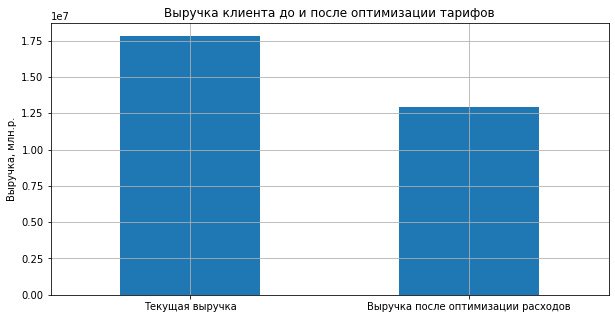

In [49]:
compare.plot(kind='bar', figsize=( 10, 5))
plt.grid()
plt.xticks(rotation=0)
plt.ylabel('Выручка, млн.р.')
plt.title('Выручка клиента до и после оптимизации тарифов')
plt.show()

После полной оптимизации выручка ожидаемо упадет, возможно мы можем предложить клиенту что-то среднее? Тогда и клиент будет доволен и колл-центры и выручка упадет не так сильно.

#### Итоговая таблица для всех клиентов (лучший тариф)

Построим итоговую таблицу по рекомнедации смены тарифов на основе данных (лучший тариф) за последний месяц, т.к. более ранние данный на текущий момент уже не актуальны

In [50]:
data_report = q_fee_crt[q_fee_crt['user_id'].isin(active_usr)]
data_report = data_report[['user_id','tariff_plan','current_value','tp_best','tp_best_name']]
data_report = data_report.reset_index(drop=True)
report = data_report[['user_id','tariff_plan','tp_best_name']]
report = report.rename(columns={'user_id':'Пользователь','tariff_plan':'Текущий тариф','tp_best_name':'Рекомендованный тариф'})

display(report.head(1))

,Пользователь,Текущий тариф,Рекомендованный тариф
0,166377,B,A


Найдем количество колл-центров которым рекомендовано сменить тарифный план на более выгодный

In [51]:
print(data_report[data_report['current_value']!=data_report['tp_best']]['user_id'].count(),
      'колл-центрам рекомендовано сменить тарифный, что составляет',
      round(data_report[data_report['current_value']!=data_report['tp_best']]['user_id'].count()\
       /data_report['user_id'].count()*100,2),
      '% от общего количества активных пользователей'
     )


147 колл-центрам рекомендовано сменить тарифный, что составляет 56.32 % от общего количества активных пользователей


#### Вернемся к расчетам и найдем средний по стоимости тариф

Найдем средний по стоимости тариф для агрегированных за квартал данных

In [52]:
q_fee_crt['tp_mid'] = q_fee_crt.apply(mid_tar, axis=1)
q_fee_crt['tp_mid_name'] = q_fee_crt.apply(mid_name, axis=1)
q_fee_crt.head(1)

,user_id,tariff_plan,current_value,tp_a,tp_b,tp_c,tp_best,tp_best_name,save_money,tp_mid,tp_mid_name
0,166377,B,158613.0,102927.8,158613.0,218140.5,102927.8,A,55685.2,158613.0,B


Найдем переплату или экономию по среднему тарифу. Если результат будет меньше и равен 0, то для такого пользователя можем оставить все как и раньше

In [53]:

q_fee_crt['save_money_mid'] = q_fee_crt['current_value'] - q_fee_crt['tp_mid']

month_fee_crt.head()

,user_id,tariff_plan,current_value,tp_a,tp_b,tp_c
0,166377,B,55667.5,36000.5,55667.5,76587.2
1,166377,B,52503.5,34062.1,52503.5,72246.4
2,166377,B,50442.0,32865.2,50442.0,69306.9
3,166391,C,1600.0,4100.0,2300.0,1600.0
4,166391,C,1300.0,4050.0,2150.0,1300.0


#### Найдем суммарную выручку клиента для всех колл-центров в случае использования средних по стоимости тарифов

In [54]:
compare_mid = q_fee_crt[['current_value','tp_mid']]
compare_mid = compare_mid.rename(columns={'current_value':'Текущая выручка', 
                                          'tp_mid':'Выручка при средних тарифах'})
compare_mid = compare_mid.sum(axis=0, numeric_only=True)

display(compare_mid)
print('На',"{0:.2%}".format((1-compare_mid[1] / compare_mid[0])), 'упадет выручка клиента после оптимизации расходов')

Текущая выручка                17817746.00
Выручка при средних тарифах    15986997.75
dtype: float64

На 10.27% упадет выручка клиента после оптимизации расходов


Падение выручки уже меньше по сравнению лучшим тарифом почти в три раза, думаю для клиента это будет более приемлемо. Построим диаграму

In [55]:
compare_all = compare.reset_index(drop=False).append(compare_mid.reset_index(drop=False)[1:])
compare_all = compare_all.rename(columns={'index':'value',0:'sum'}).reset_index(drop=True)
compare_all

,value,sum
0,Текущая выручка,17817746.00
1,Выручка после оптимизации расходов,12897975.80
2,Выручка при средних тарифах,15986997.75


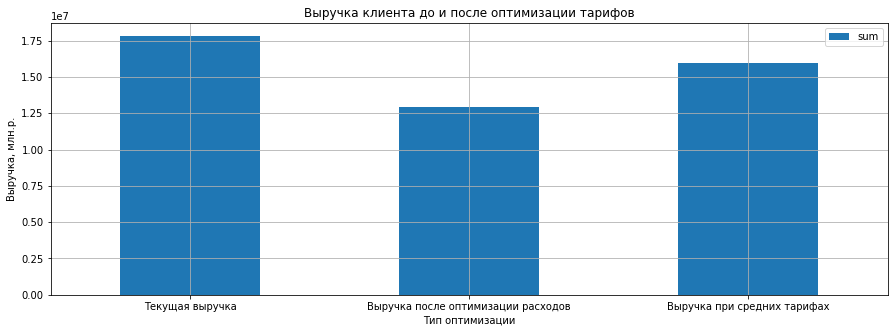

In [56]:
compare_all.plot(x='value', y='sum' ,kind='bar', figsize=( 15, 5))
plt.grid()
plt.xticks(rotation=0)
plt.xlabel('Тип оптимизации')
plt.ylabel('Выручка, млн.р.')
plt.title('Выручка клиента до и после оптимизации тарифов')
plt.show()

#### Итоговая таблица для всех клиентов (средний тариф)

Построим итоговую таблицу по рекомнедации смены тарифов на основе данных (средний тариф) за последний месяц, т.к. более ранние данные на текущий момент уже не актуальны

In [57]:
data_report_mid = q_fee_crt[q_fee_crt['user_id'].isin(active_usr)]
data_report_mid = data_report_mid[['user_id','tariff_plan','current_value','tp_mid','tp_mid_name']]
data_report_mid = data_report_mid.reset_index(drop=True)
report_mid = data_report_mid[['user_id','tariff_plan','tp_mid_name']]
report_mid = report_mid.rename(columns={'user_id':'Пользователь','tariff_plan':'Текущий тариф',
                                        'tp_mid_name':'Рекомендованный средний тариф'})

display(report_mid.head(1))

,Пользователь,Текущий тариф,Рекомендованный средний тариф
0,166377,B,B


Найдем количество колл-центров которым рекомендовано сменить тарифный план на более выгодный

In [58]:
print(data_report_mid[data_report_mid['current_value']!=data_report_mid['tp_mid']]['user_id'].count(),
      'колл-центрам рекомендовано сменить тарифный, что составляет',
      round(data_report_mid[data_report_mid['current_value']!=data_report_mid['tp_mid']]['user_id'].count()\
       /data_report_mid['user_id'].count()*100,2),
      '% от общего количества активных пользователей'
     )

56 колл-центрам рекомендовано сменить тарифный, что составляет 21.46 % от общего количества активных пользователей


**Вывод**
    
    Созданы функции для расчета возможных минимальных, средних значений в зависимости от текущей ситуации
    Если мы предлагаем клиенту использовать самые оптимальные для колл-центров тарифы, то возникает ситуация падения выручки почти на 30%. В этом случае 147 колл-центрам рекомендовано сменить тарифный, что составляет 56.32 % от общего количества активных пользователей.
    Лучшим решением будет предложить клиенту использовать средний по стоимости тариф. Тогда средняя выручка клиента упадет только на 9% и также клиент получит дополнительную лояльность клиентов. В этом случае 56 колл-центрам рекомендовано сменить тарифный, что составляет 21.46 % от общего количества активных пользователей.
    

### Посмотрим средний чек до и после оптимизации

In [59]:
average_bill_cv = q_fee_crt[['tariff_plan','current_value']]
average_bill_cv = round(average_bill_cv.groupby(['tariff_plan']).sum()\
                        /average_bill_cv.groupby(['tariff_plan']).count(),2).reset_index(drop=False)
average_bill_cv = average_bill_cv.rename(columns={'tariff_plan':'tp','current_value':'Средний чек до оптимизации'})

average_bill_best = q_fee_crt[['tp_best_name','tp_best']]
average_bill_best = round(average_bill_best.groupby(['tp_best_name']).sum()\
                         /average_bill_best.groupby(['tp_best_name']).count(),2).reset_index(drop=False)
average_bill_best = average_bill_best.rename(columns={'tp_best_name':'tp','tp_best':'Средний чек лучшие тарифы'})

average_bill_mid = q_fee_crt[['tp_mid_name','tp_mid']]
average_bill_mid = round(average_bill_mid.groupby(['tp_mid_name']).sum()\
                         /average_bill_mid.groupby(['tp_mid_name']).count(),2).reset_index(drop=False)
average_bill_mid = average_bill_mid.rename(columns={'tp_mid_name':'tp','tp_mid':'Средний чек средние тарифы'})

average_bill_all = average_bill_cv.merge(average_bill_best, on='tp')
average_bill_all = average_bill_all.merge(average_bill_mid, on='tp')
display(average_bill_all)

,tp,Средний чек до оптимизации,Средний чек лучшие тарифы,Средний чек средние тарифы
0,A,177468.65,109361.01,14597.23
1,B,41898.65,12172.48,57507.37
2,C,45125.54,4230.21,11007.67


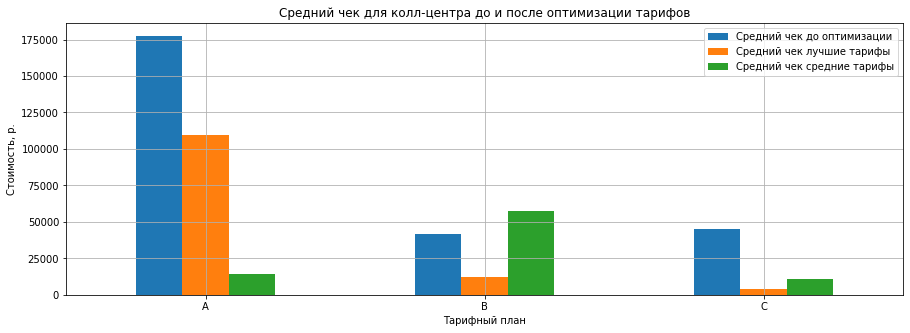

In [60]:
average_bill_all.plot(x='tp',kind='bar', figsize=( 15, 5))
plt.grid()
plt.xticks(rotation=0)
plt.ylabel('Стоимость, р.')
plt.xlabel('Тарифный план')
plt.title('Средний чек для колл-центра до и после оптимизации тарифов')
plt.legend(loc='upper right')
plt.show()

**Вывод** Не смотря на то что после оптимизации тарифов выручка клиента упадет, но средний чек после оптимизации тарифов также будет меньше в случае тарифного плана А средний чек упадет почти на порядок 

Посморим на распределение активных пользователей по тарифным планам

In [61]:
sum_act_cl_tar = q_fee_crt[q_fee_crt['user_id'].isin(active_usr)]\
                                .groupby('tariff_plan').agg({'user_id':'nunique'}).reset_index()
sum_act_cl_tar = sum_act_cl_tar.rename(columns={'user_id': 'usr_sum'})
sum_act_cl_tar

,tariff_plan,usr_sum
0,A,30
1,B,96
2,C,135


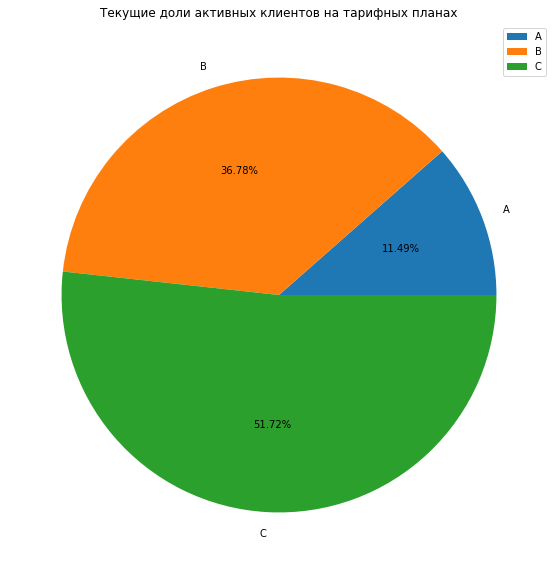

In [62]:
sum_act_cl_tar.groupby(['tariff_plan']).sum().plot(kind='pie', y='usr_sum', figsize=(10, 10), autopct='%1.2f%%', ylabel = '')
plt.title('Текущие доли активных клиентов на тарифных планах')
plt.show()

In [63]:
sum_act_cl_tp_best = q_fee_crt[q_fee_crt['user_id'].isin(active_usr)]\
                        .groupby('tp_best_name').agg({'user_id':'nunique'}).reset_index()
sum_act_cl_tp_best = sum_act_cl_tp_best.rename(columns={'user_id': 'usr_sum'})
sum_act_cl_tp_best

,tp_best_name,usr_sum
0,A,94
1,B,30
2,C,137


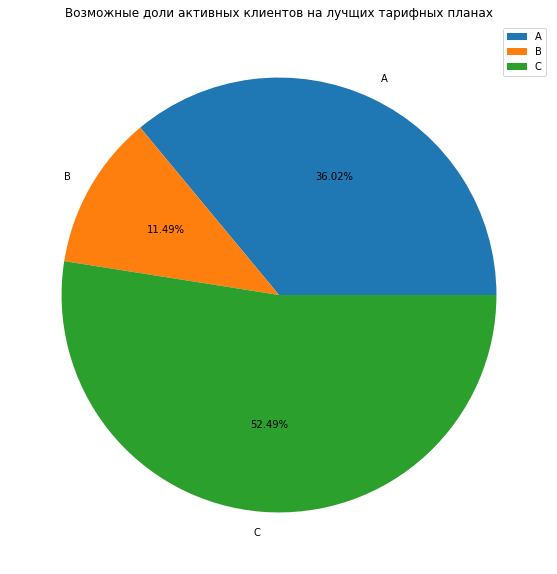

In [64]:
sum_act_cl_tp_best.groupby(['tp_best_name']).sum().plot(kind='pie', y='usr_sum', figsize=(10, 10), autopct='%1.2f%%', ylabel = '')
plt.title('Возможные доли активных клиентов на лучщих тарифных планах')
plt.show()

In [65]:
sum_act_cl_tp_mid = q_fee_crt[q_fee_crt['user_id'].isin(active_usr)]\
                        .groupby('tp_mid_name').agg({'user_id':'nunique'}).reset_index()
sum_act_cl_tp_mid = sum_act_cl_tp_mid.rename(columns={'user_id': 'usr_sum'})
sum_act_cl_tp_mid

,tp_mid_name,usr_sum
0,A,13
1,B,232
2,C,16


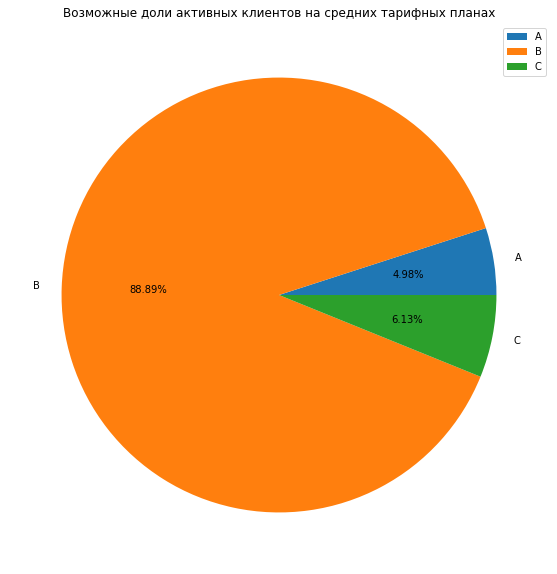

In [66]:
sum_act_cl_tp_mid.groupby(['tp_mid_name']).sum().plot(kind='pie', y='usr_sum', figsize=(10, 10), autopct='%1.2f%%', ylabel = '')
plt.title('Возможные доли активных клиентов на средних тарифных планах')
plt.show()

In [67]:
print(df[df['month']==df['month'].max()]['user_id'].nunique(), '- активный пользователь в исходных данных')
print(sum_act_cl_tar['usr_sum'].sum(),
      '- активный пользователь по данным таблицы "Текущие доли активных клиентов на тарифных планах"')
print(sum_act_cl_tp_best['usr_sum'].sum(),
      '- активный пользователь по данным таблицы "Возможные доли активных клиентов на лучщих тарифных планах"')
print(sum_act_cl_tp_mid['usr_sum'].sum(),
      '- активный пользователь по данным таблицы "Возможные доли активных клиентов на средних тарифных планах"')

261 - активный пользователь в исходных данных
261 - активный пользователь по данным таблицы "Текущие доли активных клиентов на тарифных планах"
261 - активный пользователь по данным таблицы "Возможные доли активных клиентов на лучщих тарифных планах"
261 - активный пользователь по данным таблицы "Возможные доли активных клиентов на средних тарифных планах"


## Проверка гипотез
### Гипотеза: среднее время дозвона с тарифными планами А и В отличается

Сформулируем гипотезы<br>
$H_{0}$: среднее время дозвона с тарифными планами А и В равно<br>
$H_{1}$: среднее время дозвона с тарифными планами А и В различно

In [68]:
data['dialing_time'] = (data['total_call_duration'] - data['call_duration']) / data['calls_count']
data_a = data[data['tariff_plan']=='A']
data_b = data[data['tariff_plan']=='B']

In [69]:
results = stats.ttest_ind(data_a['dialing_time'], data_b['dialing_time'], alternative = 'two-sided')
alpha = 0.05

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

p-значение: 0.17540924303041866
Нельзя отвергнуть нулевую гипотезу


**Вывод** Нулевая гипотеза не опровергнута, следовательно среднее время дозвона с тарифными планами А и В скорее всего не отличается.

### Гипотеза: среднее время дозвона с тарифными планами А и C отличается

Сформулируем гипотезы<br>
$H_{0}$: среднее время дозвона с тарифными планами А и C равно<br>
$H_{1}$: среднее время дозвона с тарифными планами А и C различно

In [70]:
data_c = data[data['tariff_plan']=='C']

In [71]:
results = stats.ttest_ind(data_a['dialing_time'], data_c['dialing_time'], alternative = 'two-sided')
alpha = 0.05

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

p-значение: 9.512816127822485e-12
Отвергаем нулевую гипотезу


**Вывод** Нулевая гипотеза опровергнута, следовательно среднее время дозвона с тарифными планами А и C скорее всего отличается.

### Гипотеза: среднее время дозвона с тарифными планами B и C отличается

Сформулируем гипотезы<br>
$H_{0}$: среднее время дозвона с тарифными планами B и C равно<br>
$H_{1}$: среднее время дозвона с тарифными планами B и C различно

In [72]:
results = stats.ttest_ind(data_b['dialing_time'], data_c['dialing_time'], alternative = 'two-sided')
alpha = 0.05

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

p-значение: 1.9777580447512673e-16
Отвергаем нулевую гипотезу


**Вывод** Нулевая гипотеза опровергнута, следовательно среднее время дозвона с тарифными планами B и C скорее всего отличается.

**Вывод по гипотезам** Тарифы A и B скорее всего имеют одинаковое среднее время дозвона в отличе от тарифа C

## **Общий вывод**


    1. Предобработка данных
        -Названия столбцов в датасетах корректны
		-Датасет clients 
			содержит 732 строки пропусков в данных нет, 
			для поля date_start преобразован тип.
		-Датасет dt
			содержит 53902 строки
			удалены явные дубликаты
			Пропуски в 
				поле internal (удалены из-за малого количества) и 
				operator_id (оставлено без изменений т.к. не повлияет на рачеты, основная масса пропущеные звонки)
			Поля date, internal и operator_id  - преобразован тип данных
			после обработки датасет содержит 48892 строки

    2. Исследовательский анализ данных
        Обнаружены три возможных аномалии:
             1. 3.49 звонка совершается каждую минуту в случае максимальной аномалии.
             Складывается впечатление, что за большим количеством звонков у клиентов скрываются боты-звонилки или это входящие звонки. Если звонки исходящие, то бот не дозвонился и перешел к следующему звонку и это хорошо для оператора. Если звонки входящие, то скорее всего абонент не дождался ответа и тут колл-центр должен увеличить свою мощность, что опять же хорошо для нашего клиента. Оставляем без изменений
             2. Аномалия call_duration - был обнаружен один аномальный с 283 записями. Этот оператор удале в силу малого количества записей.
             3. Аномалия total_call_duration - после удаления аномалий в call_duration аномалии не обнаружены.

    3. Созданы функции для расчета возможных минимальных, средних значений в зависимости от текущей ситуации
        Если мы предлагаем клиенту использовать самые оптимальные для колл-центров тарифы, то возникает ситуация падения выручки почти на 30%. В этом случае 147 колл-центрам рекомендовано сменить тарифный, что составляет 56.32 % от общего количества активных пользователей.
        Лучшим решением будет предложить клиенту использовать средний по стоимости тариф. Тогда средняя выручка клиента упадет только на 9% и также клиент получит дополнительную лояльность клиентов. В этом случае 59 колл-центрам будет рекомендовано сменить тарифный, что составляет 22.61 % от общего количества активных пользователей.
        Не смотря на то что после оптимизации тарифов выручка клиента упадет, но средний чек после оптимизации тарифов также будет меньше в случае тарифного плана А средний чек упадет почти на порядок
        В случае перевода активных клиентов на средние тарифы почти 80% клиентов будет использовать тарифный план B. Возможно имеет смысл пересмотреть тарифные планы А и С.
    
    4. Проверка гипотез
        4.1 Была выдвинута гипотеза что среднее время дозвона с тарифными планами А и В равно.
        Нулевая гипотеза не опровергнута, следовательно среднее время дозвона с тарифными планами А и В скорее всего не отличается.
        4.2 Была выдвинута гипотеза что среднее время дозвона с тарифными планами А и C равно.
        Нулевая гипотеза опровергнута, следовательно среднее время дозвона с тарифными планами А и C скорее всего отличается.
        4.3 Была выдвинута гипотеза что среднее время дозвона с тарифными планами B и C равно.
        Нулевая гипотеза опровергнута, следовательно среднее время дозвона с тарифными планами B и C скорее всего отличается.
    Тарифы A и B скорее всего имеют одинаковое среднее время дозвона в отличе от тарифа C